# Sentiment Analysis On Tweets

In [64]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-airline-sentiment


In [65]:
# Reading the dataset
import pandas as pd

Tweet_df = pd.read_csv(path + "/Tweets.csv")
Tweet_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## DataSet Overview
- Target variable = airline sentiment
- Text input = text

In [66]:
# Import libraries
import nltk
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [67]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    return text


In [68]:
# Text Vectorization to convert text into Numerical format

from sklearn.feature_extraction.text import TfidfVectorizer

# Apply the preprocessing function to create the 'cleaned_text' column
Tweet_df['cleaned_text'] = Tweet_df['text'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(Tweet_df['cleaned_text'])


In [69]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(Tweet_df['airline_sentiment'])

## Data Visualization


<ipython-input-70-275986206>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')


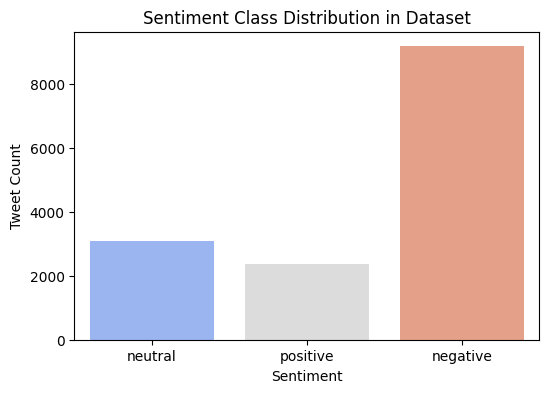

In [70]:
# Check if the data is balanced
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')
plt.title('Sentiment Class Distribution in Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()



There is a class imbalance where the negatives are extremely high.
SMOTE is the apllied on the training dataset to reduuce the biased effect.

## The Model

In [71]:
# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [72]:
# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [73]:
# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      1845
     neutral       0.59      0.68      0.63       617
    positive       0.70      0.71      0.71       466

    accuracy                           0.79      2928
   macro avg       0.73      0.75      0.74      2928
weighted avg       0.80      0.79      0.79      2928



- The model achieves an accuracy of 79% which suggets that it is a good fit.

In [74]:
# Confusion Matrix

confusion_mat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Define sentiment labels
labels = ['Neg', 'Neu', 'Pos']

# Create labeled confusion matrix using pandas
df_confusion = pd.DataFrame(
    confusion_mat,
    index=pd.MultiIndex.from_product([['Actual'], labels]),
    columns=pd.MultiIndex.from_product([['Predicted'], labels])
)

print("Confusion Matrix:")
print(df_confusion)


Confusion Matrix:
           Predicted          
                 Neg  Neu  Pos
Actual Neg      1560  211   74
       Neu       132  420   65
       Pos        59   76  331


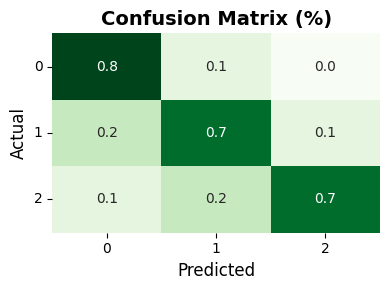

In [75]:
# Calculate the normalized confusion matrix
conf_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Visualizing the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_normalized.round(1), annot=True, fmt='.1f', cmap='Greens', cbar=False)
plt.title("Confusion Matrix (%)", fontsize=14, weight='bold')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- The model demonstrates strong perfomance in classifying the sentiment categories with 70% and 80%.